# Figure 6 - Acceleration quantification

Create the figure panels describing the algorithmic acceleration provided by the SONIC model validation against the detailed NICE model.

### Matplotlib parameters

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'arial'

### Imports

In [2]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.core import NeuronalBilayerSonophore, PulsedProtocol
from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from utils import saveFigsAsPDF, cm2inch, getCompTimesQuant, getLookupsCompTime

Set high logging level to avoid extra logging

In [3]:
logger.setLevel(logging.ERROR)

### Input directory

Indicate here the directory that contains the NICE and SONIC simulation files (*comparisons* sub-folder)

In [4]:
inputdir = input('Select input directory: ')

Select input directory:  C:\Users\lemaire\Documents\SONIC paper data\comparisons


### Plot parameters

In [5]:
figindex = 6
fs = 15
lw = 2
ps = 8
figsize = cm2inch(11, 11.6)
time_indicators = [1, 60, 60**2, 60**2 * 24, 60**2 * 24 * 7]
time_indicators_labels = ['1 s', '1 min', '1 hour', '1 day', '1 week']
figs = {}

### Simulation parameters

In [6]:
a = 32e-9  # m
Adrive = 100e3  # Pa
Fdrive = 500e3  # Hz
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.0
cov = 1.0

CW_pp = PulsedProtocol(tstim, toffset)

In [7]:
pneuron = getPointNeuron('RS')
nbls = NeuronalBilayerSonophore(a, pneuron)
tcomp_lookup = getLookupsCompTime(pneuron)

## Panel A: acceleration across US amplitudes (CW, RS neuron)

Comparison of computation times vs. amplitude for CW stimuli

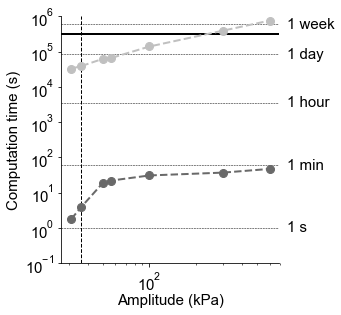

In [9]:
xlabel = 'Amplitude (kPa)'
Athr = nbls.titrate(Fdrive, CW_pp)
regime_amps = np.array([Athr - 5e3, Athr, Athr + 20e3])  # Pa
suprathr_amps = np.array([50, 100, 300, 600]) * 1e3  # Pa
amps = np.sort(np.hstack((regime_amps, suprathr_amps)))  # Pa
fnames = {'full': [], 'sonic': []}
for x in amps:
    for method in ['sonic', 'full']:
        fnames[method].append(f'{nbls.filecode(Fdrive, x, CW_pp, cov, method, None)}.pkl')
data_fpaths = {k: [os.path.join(inputdir, fname) for fname in v] for k, v in fnames.items()}
comptimes_fpath = os.path.join(inputdir, '{}_comptimes_vs_amplitude.csv'.format(pneuron.name))
comptimes_vs_amps = getCompTimesQuant(inputdir, pneuron.name, amps * 1e-3, xlabel, data_fpaths, comptimes_fpath)

fig, ax = plt.subplots(figsize=figsize)
plt.subplots_adjust(bottom=0.2, left=0.25, right=0.95, top=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(xlabel, fontsize=fs, labelpad=1)
ax.set_ylabel('Computation time (s)', fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-1, 1e6))
for y, lbl in zip(time_indicators, time_indicators_labels):
    ax.axhline(y, linewidth=0.5, linestyle='--', c='k')
    ax.text((amps.max() * 1e-3) * 1.3, y, lbl, horizontalalignment='left', verticalalignment='center', fontsize=fs)
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0)
ax.axhline(tcomp_lookup, color='k', linewidth=lw)
ax.axvline(Athr * 1e-3, linestyle='--', color='k', linewidth=1)
colors = ['silver', 'dimgrey']
for i, key in enumerate(comptimes_vs_amps):
    ax.plot(amps * 1e-3, comptimes_vs_amps[key], 'o--', color=colors[i], linewidth=lw, label=key, markersize=ps)
for item in ax.get_yticklabels():
        item.set_fontsize(fs)
for item in ax.get_xticklabels():
    item.set_fontsize(fs)
figs['a'] = fig

## Panel B: acceleration across US frequencies (CW, RS neuron)

Comparison of computation times vs. US frequency for CW stimuli

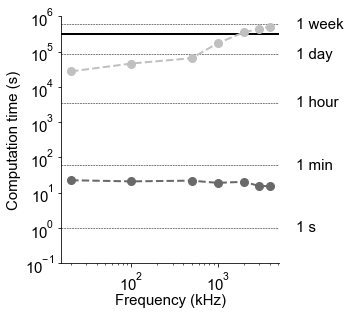

In [10]:
xlabel = 'Frequency (kHz)'
freqs = np.array([20e3, 100e3, 500e3, 1e6, 2e6, 3e6, 4e6])  # Hz
fnames = {'full': [], 'sonic': []}
for x in freqs:
    A = nbls.titrate(x, CW_pp) + 20e3  # Pa
    for method in ['sonic', 'full']:
        fnames[method].append(f'{nbls.filecode(x, A, CW_pp, cov, method, None)}.pkl')
data_fpaths = {k: [os.path.join(inputdir, fname) for fname in v] for k, v in fnames.items()}
comptimes_fpath = os.path.join(inputdir, '{}_comptimes_vs_frequency.csv'.format(pneuron.name))
comptimes_vs_freqs = getCompTimesQuant(inputdir, pneuron.name, freqs * 1e-3, xlabel, data_fpaths, comptimes_fpath)

fig, ax = plt.subplots(figsize=figsize)
plt.subplots_adjust(bottom=0.2, left=0.25, right=0.95, top=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(xlabel, fontsize=fs, labelpad=1)
ax.set_ylabel('Computation time (s)', fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-1, 1e6))
for y, lbl in zip(time_indicators, time_indicators_labels):
    ax.axhline(y, linewidth=0.5, linestyle='--', c='k')
    ax.text((freqs.max() * 1e-3) * 2, y, lbl, horizontalalignment='left', verticalalignment='center', fontsize=fs)
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0)
ax.axhline(tcomp_lookup, color='k', linewidth=lw)
colors = ['silver', 'dimgrey']
for i, key in enumerate(comptimes_vs_freqs):
    ax.plot(freqs * 1e-3, comptimes_vs_freqs[key], 'o--', color=colors[i], linewidth=lw, label=key, markersize=ps)
for item in ax.get_yticklabels():
        item.set_fontsize(fs)
for item in ax.get_xticklabels():
    item.set_fontsize(fs)
figs['b'] = fig

## Panel C: acceleration across sonophore radii (CW, RS neuron)

Comparison of computation times vs. sonophore radius for CW stimuli

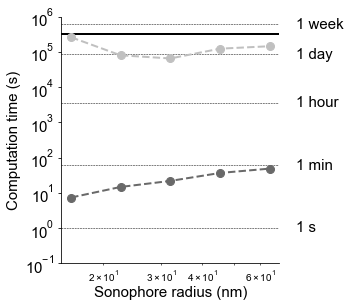

In [11]:
xlabel = 'Sonophore radius (nm)'
radii = np.array([16, 22.6, 32, 45.3, 64]) * 1e-9  # nm
fnames = {'full': [], 'sonic': []}
for x in radii:
    nbls = NeuronalBilayerSonophore(x, pneuron)
    A = nbls.titrate(Fdrive, CW_pp) + 20e3  # Pa
    for method in ['sonic', 'full']:
        fnames[method].append(f'{nbls.filecode(Fdrive, A, CW_pp, cov, method, None)}.pkl')
data_fpaths = {k: [os.path.join(inputdir, fname) for fname in v] for k, v in fnames.items()}
comptimes_fpath = os.path.join(inputdir, '{}_comptimes_vs_radius.csv'.format(pneuron.name))
comptimes_vs_radii = getCompTimesQuant(inputdir, pneuron.name, radii * 1e9, xlabel, data_fpaths, comptimes_fpath)

fig, ax = plt.subplots(figsize=figsize)
plt.subplots_adjust(bottom=0.2, left=0.25, right=0.95, top=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(xlabel, fontsize=fs, labelpad=1)
ax.set_ylabel('Computation time (s)', fontsize=fs)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-1, 1e6))
for y, lbl in zip(time_indicators, time_indicators_labels):
    ax.axhline(y, linewidth=0.5, linestyle='--', c='k')
    ax.text((radii.max() * 1e9) * 1.2, y, lbl, horizontalalignment='left', verticalalignment='center', fontsize=fs)
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0)
ax.axhline(tcomp_lookup, color='k', linewidth=lw)
colors = ['silver', 'dimgrey']
for i, key in enumerate(comptimes_vs_radii):
    ax.plot(radii * 1e9, comptimes_vs_radii[key], 'o--', color=colors[i], linewidth=lw, label=key, markersize=ps)
for item in ax.get_yticklabels():
        item.set_fontsize(fs)
for item in ax.get_xticklabels():
    item.set_fontsize(fs)
figs['c'] = fig

## Panel D: acceleration across duty cycles (RS and LTS neuron)

Comparison of computation times vs. duty cycle for RS and LTS neurons

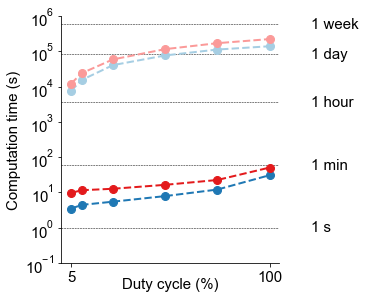

In [12]:
xlabel = 'Duty cycle (%)'
colors = list(plt.get_cmap('Paired').colors[:6])
del colors[2:4]
neurons = ['RS', 'LTS']
DCs = np.array([5, 10, 25, 50, 75, 100]) * 1e-2

fig, ax = plt.subplots(figsize=figsize)
plt.subplots_adjust(bottom=0.2, left=0.25, right=0.95, top=0.95)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(xlabel, fontsize=fs, labelpad=-7)
ax.set_ylabel('Computation time (s)', fontsize=fs)
ax.set_xticks([DCs.min() * 1e2, DCs.max() * 1e2])
ax.set_yscale('log')
ax.set_ylim((1e-1, 1e6))
for y, lbl in zip(time_indicators, time_indicators_labels):
    ax.axhline(y, linewidth=0.5, linestyle='--', c='k')
    ax.text((DCs.max() * 1e2) * 1.2, y, lbl, horizontalalignment='left', verticalalignment='center', fontsize=fs)
ax.get_yaxis().set_tick_params(which='minor', size=0)
ax.get_yaxis().set_tick_params(which='minor', width=0)

for i, neuron in enumerate(neurons):
    fnames = {'full': [], 'sonic': []}
    pneuron = getPointNeuron(neuron)
    nbls = NeuronalBilayerSonophore(a, pneuron)
    for x in DCs:
        for method in ['sonic', 'full']:
            fnames[method].append(f'{nbls.filecode(Fdrive, Adrive, PulsedProtocol(tstim, toffset, PRF, x), cov, method, None)}.pkl')
    data_fpaths = {k: [os.path.join(inputdir, fname) for fname in v] for k, v in fnames.items()}
    comptimes_fpath = os.path.join(inputdir, '{}_comptimes_vs_DC.csv'.format(pneuron.name))
    comptimes_vs_DCs = getCompTimesQuant(inputdir, pneuron.name, DCs * 1e2, xlabel, data_fpaths, comptimes_fpath)
    ax.plot(DCs * 1e2, comptimes_vs_DCs['full'], 'o--', color=colors[2 * i], linewidth=lw, markersize=ps)
    ax.plot(DCs * 1e2, comptimes_vs_DCs['sonic'], 'o--', color=colors[2 * i + 1], linewidth=lw,
            markersize=ps, label=neuron)
    
for item in ax.get_yticklabels():
    item.set_fontsize(fs)
for item in ax.get_xticklabels():
    item.set_fontsize(fs)

figs['d'] = fig

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [12]:
saveFigsAsPDF(figs, figindex)